In [1]:


import pandas as pd
import numpy as np


TRAIN_FEATURES_PATH = "c:/Users/user/poverty-prediction/data/raw/train_hh_features.csv"
TRAIN_GT_PATH = "c:/Users/user/poverty-prediction/data/raw/train_hh_gt.csv"
TEST_FEATURES_PATH = "c:/Users/user/poverty-prediction/data/raw/test_hh_features.csv"

train_features = pd.read_csv(TRAIN_FEATURES_PATH)
train_gt = pd.read_csv(TRAIN_GT_PATH)
test_features = pd.read_csv(TEST_FEATURES_PATH)

# Merge train features + target (safe 1–1 merge)
train_df = train_features.merge(
    train_gt,
    on=["survey_id", "hhid"],
    how="inner",
    validate="one_to_one"
)


TARGET_COL = "cons_ppp17"
WEIGHT_COL = "weight"
ID_COLS = ["survey_id", "hhid"]

PROTECTED_COLS = ID_COLS + [TARGET_COL, WEIGHT_COL]

# Feature columns = everything else
FEATURE_COLS = [c for c in train_df.columns if c not in PROTECTED_COLS]

print("Train shape:", train_df.shape)
print("Test shape:", test_features.shape)
print("Number of feature columns:", len(FEATURE_COLS))
print("Protected columns:", PROTECTED_COLS)


Train shape: (104234, 89)
Test shape: (103023, 88)
Number of feature columns: 85
Protected columns: ['survey_id', 'hhid', 'cons_ppp17', 'weight']


## Cell 2 — Target transformation (log per-capita consumption)

Ο στόχος μας (`cons_ppp17`) ακολουθεί **log-normal κατανομή**, όπως επιβεβαιώθηκε στο EDA.
Για αυτό, πριν από οποιοδήποτε modeling:

- μετασχηματίζουμε το target σε **λογαριθμική κλίμακα**,
- κρατάμε τον αρχικό στόχο ανέπαφο για:
  - poverty rate computation,
  - inverse transform των προβλέψεων.

### Γιατί log-transform
- Σταθεροποιεί τη διασπορά (heteroskedasticity)
- Μειώνει την επίδραση των outliers
- Βελτιώνει την απόδοση σε quantiles / tails
- Κάνει το regression πιο “γραμμικό” για tree-based models

### Τι ΔΕΝ κάνουμε
- Δεν κανονικοποιούμε (standardize) το target
- Δεν αγγίζουμε weights
- Δεν πειράζουμε test δεδομένα

Ο μετασχηματισμός είναι:
\[
y = \log(\text{cons\_ppp17})
\]
και στο τέλος:
\[
\hat{c} = \exp(\hat{y})
\]


In [2]:

# Create log-transformed target
train_df["log_cons_ppp17"] = np.log(train_df["cons_ppp17"])


print("Original target stats:")
print(train_df["cons_ppp17"].describe())

print("\nLog-transformed target stats:")
print(train_df["log_cons_ppp17"].describe())


Original target stats:
count    104234.000000
mean         11.555229
std          10.034225
min           0.359563
25%           5.439294
50%           8.774002
75%          14.216931
max         236.115680
Name: cons_ppp17, dtype: float64

Log-transformed target stats:
count    104234.000000
mean          2.189702
std           0.701294
min          -1.022867
25%           1.693649
50%           2.171793
75%           2.654434
max           5.464322
Name: log_cons_ppp17, dtype: float64


## Cell 3 — Dropping constant / non-informative features

Στόχος αυτού του cell είναι να αφαιρέσουμε features που **δεν μεταφέρουν καμία πληροφορία**
και άρα:
- δεν βοηθούν το μοντέλο,
- αυξάνουν άσκοπα τη διάσταση,
- μπορεί να μπερδέψουν regularization / splits.

### Κριτήριο αφαίρεσης
Ένα feature θεωρείται **μη-ενημερωτικό** αν:
- έχει **μία και μόνο μία μοναδική τιμή** σε όλο το training set,
- άρα δεν μπορεί να διαχωρίσει κανένα household από κάποιο άλλο.

Στο EDA εντοπίσαμε τέτοια στήλη (`com`).
Σε αυτό το cell:
- το επιβεβαιώνουμε με prints,
- και την αφαιρούμε **μόνο από το feature space**.


In [3]:

# Compute number of unique values per feature
nunique_per_feature = train_df[FEATURE_COLS].nunique(dropna=False)

# Constant features: exactly 1 unique value
constant_features = nunique_per_feature[nunique_per_feature == 1].index.tolist()

print("Constant / non-informative features detected:")
constant_features
# Show value counts for each constant feature (proof)
for c in constant_features:
    print(f"\nFeature: {c}")
    print(train_df[c].value_counts(dropna=False))
# Drop constant features from train and test feature sets
train_df = train_df.drop(columns=constant_features)
test_features = test_features.drop(columns=constant_features, errors="ignore")

# Update FEATURE_COLS after dropping
FEATURE_COLS = [c for c in FEATURE_COLS if c not in constant_features]

print("\nAfter dropping constants:")
print("Remaining feature columns:", len(FEATURE_COLS))



Constant / non-informative features detected:

Feature: com
com
1    104234
Name: count, dtype: int64

After dropping constants:
Remaining feature columns: 84


## Cell 4 — Encoding low-cardinality string features (binary + consumed)

Στόχος:
1) Να εντοπίσουμε ποιες string (object) στήλες έχουν **μόνο 2 τιμές** (binary categorical).
2) Να εντοπίσουμε τις `consumed*` στήλες που έχουν **Yes/No/(NaN)**.
3) Να εφαρμόσουμε **απλές, deterministic μετατροπές** σε 0/1.

Γιατί τώρα:
- Είναι ασφαλείς μετασχηματισμοί που **δεν απαιτούν fitting** (όπως one-hot με train stats).
- Μειώνουν πολυπλοκότητα άμεσα.
- Κρατούν καθαρή τη σημασιολογία (ειδικά για food indicators).




## Cell 4 — Binary categorical encoding (2 unique values only)

Σε αυτό το cell:
- Εντοπίζουμε object columns που έχουν **ακριβώς 2 μοναδικές τιμές**
- Κάνουμε **απλό binary mapping (0/1)**
- Κάνουμε μόνο **ελαφρύ string cleanup** (strip)
- ΤΥΠΩΝΟΥΜΕ ρητά:
  - ποια στήλη χαρτογραφήθηκε
  - ποιες ήταν οι αρχικές τιμές
  - ποιο mapping εφαρμόστηκε



In [4]:


# Find feature columns with exactly 2 unique values (including NaN if present)
binary_cols_any_dtype = []
for c in FEATURE_COLS:
    nun = train_df[c].nunique(dropna=True)
    if nun == 2:
        binary_cols_any_dtype.append(c)

print("Binary columns (2 unique values) regardless of dtype:", len(binary_cols_any_dtype))
print(binary_cols_any_dtype[:50])
# Show value counts for a few important suspected binaries (if they exist)
suspects = ["male", "owner", "water", "toilet", "sewer", "elect", "urban", "any_nonagric", "employed"]
for c in suspects:
    if c in train_df.columns:
        print(f"\nColumn: {c} (dtype={train_df[c].dtype})")
        print(train_df[c].value_counts(dropna=False).head(10))
# Inspect consumed columns state (dtype + value counts)
consumed_cols = [c for c in FEATURE_COLS if c.lower().startswith("consumed")]

print("Consumed cols found:", len(consumed_cols))
if len(consumed_cols) > 0:
    for c in consumed_cols[:5]:
        print(f"\n{c} (dtype={train_df[c].dtype})")
        print(train_df[c].value_counts(dropna=False).head(10))


Binary columns (2 unique values) regardless of dtype: 66
['male', 'owner', 'water', 'toilet', 'sewer', 'elect', 'employed', 'any_nonagric', 'region1', 'region2', 'region3', 'region4', 'region5', 'region6', 'region7', 'urban', 'consumed100', 'consumed200', 'consumed300', 'consumed400', 'consumed500', 'consumed600', 'consumed700', 'consumed800', 'consumed900', 'consumed1000', 'consumed1100', 'consumed1200', 'consumed1300', 'consumed1400', 'consumed1500', 'consumed1600', 'consumed1700', 'consumed1800', 'consumed1900', 'consumed2000', 'consumed2100', 'consumed2200', 'consumed2300', 'consumed2400', 'consumed2500', 'consumed2600', 'consumed2700', 'consumed2800', 'consumed2900', 'consumed3000', 'consumed3100', 'consumed3200', 'consumed3300', 'consumed3400']

Column: male (dtype=object)
male
Male      75657
Female    28577
Name: count, dtype: int64

Column: owner (dtype=object)
owner
Owner        76540
Not owner    27694
Name: count, dtype: int64

Column: water (dtype=object)
water
Access     

In [5]:


obj_cols = train_df[FEATURE_COLS].select_dtypes(include=["object"]).columns.tolist()

# Strict binary = exactly 2 unique non-null values
binary_obj_cols = []
for c in obj_cols:
    nun = train_df[c].nunique(dropna=True)
    if nun == 2:
        binary_obj_cols.append(c)

# Exclusions handled in separate cell
consumed_cols = [c for c in FEATURE_COLS if c.lower().startswith("consumed")]
binary_obj_cols = [c for c in binary_obj_cols if c not in consumed_cols and c != "employed"]

print("Binary object cols to map (strict 2-values):", len(binary_obj_cols))
print(binary_obj_cols)

binary_mappings = {}

for c in binary_obj_cols:
    vals = sorted(train_df[c].dropna().astype(str).str.strip().unique().tolist())
    mapping = {vals[0]: 0, vals[1]: 1}
    binary_mappings[c] = mapping

    train_df[c] = train_df[c].astype(str).str.strip().map(mapping).astype("int8")
    test_features[c] = test_features[c].astype(str).str.strip().map(mapping).astype("int8")

print("\nApplied mappings:")
for c, m in binary_mappings.items():
    print(f"  - {c}: {m}")


Binary object cols to map (strict 2-values): 8
['male', 'owner', 'water', 'toilet', 'sewer', 'elect', 'any_nonagric', 'urban']

Applied mappings:
  - male: {'Female': 0, 'Male': 1}
  - owner: {'Not owner': 0, 'Owner': 1}
  - water: {'Access': 0, 'No access': 1}
  - toilet: {'Access': 0, 'No access': 1}
  - sewer: {'Access': 0, 'No access': 1}
  - elect: {'Access': 0, 'No access': 1}
  - any_nonagric: {'No': 0, 'Yes': 1}
  - urban: {'Rural': 0, 'Urban': 1}


In [6]:

# Identify consumed columns
consumed_cols = [c for c in FEATURE_COLS if c.lower().startswith("consumed")]

print("Consumed columns:", len(consumed_cols))
print("Example BEFORE mapping:", consumed_cols[0])
print(train_df[consumed_cols[0]].value_counts(dropna=False).head(5))

# Apply mapping to consumed*
for c in consumed_cols:
    train_df[c] = (
        train_df[c]
        .astype(str).str.strip()
        .map({"Yes": 1, "No": 0})
        .fillna(0)
        .astype("int8")
    )
    test_features[c] = (
        test_features[c]
        .astype(str).str.strip()
        .map({"Yes": 1, "No": 0})
        .fillna(0)
        .astype("int8")
    )

print("\nExample AFTER mapping:", consumed_cols[0])
print(train_df[consumed_cols[0]].value_counts(dropna=False).head(5))

print("\nConsumed sums (first 10):")
print(train_df[consumed_cols[:10]].sum())
print("\nEmployed BEFORE mapping:")
print(train_df["employed"].value_counts(dropna=False))

train_df["employed"] = (
    train_df["employed"]
    .astype(str).str.strip()
    .map({"Employed": 1, "Not employed": 0})
    .fillna(0)
    .astype("int8")
)

test_features["employed"] = (
    test_features["employed"]
    .astype(str).str.strip()
    .map({"Employed": 1, "Not employed": 0})
    .fillna(0)
    .astype("int8")
)

print("\nEmployed AFTER mapping:")
print(train_df["employed"].value_counts(dropna=False))


Consumed columns: 50
Example BEFORE mapping: consumed100
consumed100
Yes    95063
No      9169
NaN        2
Name: count, dtype: int64

Example AFTER mapping: consumed100
consumed100
1    95063
0     9171
Name: count, dtype: int64

Consumed sums (first 10):
consumed100     95063
consumed200     60975
consumed300     79136
consumed400     78889
consumed500     91161
consumed600     81632
consumed700     92929
consumed800     60983
consumed900     84764
consumed1000    32771
dtype: int64

Employed BEFORE mapping:
employed
Employed        90105
Not employed    14084
NaN                45
Name: count, dtype: int64

Employed AFTER mapping:
employed
1    90105
0    14129
Name: count, dtype: int64


## Cell C1 — Inspect `water_source` (categories + missingness)

Στόχος: Να δούμε τις κατηγορίες του `water_source`, τη συχνότητά τους και αν υπάρχουν NaN.
Μετά αποφασίζουμε αν το NaN σημαίνει "Unknown" και αν χρειάζεται grouping σπάνιων κατηγοριών.


In [7]:
col = "water_source"

print("Column:", col)
print("dtype:", train_df[col].dtype)
print("\nMissing values:", train_df[col].isna().sum())

print("\nTop categories (train):")
print(train_df[col].value_counts(dropna=False).head(20))

# Cardinality
print("\nUnique non-null categories:", train_df[col].nunique(dropna=True))


Column: water_source
dtype: object

Missing values: 0

Top categories (train):
water_source
Piped water into dwelling    81514
Surface water                 7619
Other                         4180
Piped water to yard/plot      3782
Protected dug well            2641
Public tap or standpipe       1832
Tanker-truck                  1539
Protected spring              1127
Name: count, dtype: int64

Unique non-null categories: 8


## Cell C2 — Inspect `sanitation_source` (categories + missingness)

Στόχος: Να δούμε τις κατηγορίες του `sanitation_source` και ιδιαίτερα αν υπάρχει "Other" ή "No facilities".
Αυτό επηρεάζει έντονα consumption και poverty thresholds.


In [8]:
col = "sanitation_source"

print("Column:", col)
print("dtype:", train_df[col].dtype)
print("\nMissing values:", train_df[col].isna().sum())

print("\nTop categories (train):")
print(train_df[col].value_counts(dropna=False).head(25))

print("\nUnique non-null categories:", train_df[col].nunique(dropna=True))


Column: sanitation_source
dtype: object

Missing values: 0

Top categories (train):
sanitation_source
A piped sewer system              62360
A septic tank                     10914
Pit latrine with slab             10614
No facilities or bush or field     9587
Pit latrine                        6487
Other                              4272
Name: count, dtype: int64

Unique non-null categories: 6


## Cell C4 — Inspect `dweltyp` (housing type)

Στόχος: Να δούμε τις κατηγορίες του τύπου κατοικίας και αν υπάρχουν NaN/σπάνιες κατηγορίες.
Το dwelling type είναι ισχυρό proxy wealth feature.


In [9]:
col = "dweltyp"

print("Column:", col)
print("dtype:", train_df[col].dtype)
print("\nMissing values:", train_df[col].isna().sum())

print("\nTop categories (train):")
print(train_df[col].value_counts(dropna=False).head(20))

print("\nUnique non-null categories:", train_df[col].nunique(dropna=True))


Column: dweltyp
dtype: object

Missing values: 1206

Top categories (train):
dweltyp
Detached house                 93302
Separate apartment              4090
Several buildings connected     3430
Other                           2140
NaN                             1206
Improvised housing unit           66
Name: count, dtype: int64

Unique non-null categories: 5


In [10]:

col = "dweltyp"

print("Missing BEFORE:", train_df[col].isna().sum())

# Replace NaN with explicit category
train_df[col] = train_df[col].fillna("Unknown")
test_features[col] = test_features[col].fillna("Unknown")

# Set categorical dtype
train_df[col] = train_df[col].astype("category")
test_features[col] = test_features[col].astype("category")

print("Missing AFTER:", train_df[col].isna().sum())
print("\nCategories:")
print(train_df[col].cat.categories)


Missing BEFORE: 1206
Missing AFTER: 0

Categories:
Index(['Detached house', 'Improvised housing unit', 'Other',
       'Separate apartment', 'Several buildings connected', 'Unknown'],
      dtype='object')


## Cell C3 — Inspect `educ_max` (ordinal-ish categorical)

Στόχος: Να δούμε αν το `educ_max` έχει φυσική σειρά (ordinal) ή αν θα το κρατήσουμε ως categorical.
Συνήθως είναι ordinal, αλλά προχωράμε με evidence: κατηγορίες + NaN.


In [11]:
col = "educ_max"

print("Column:", col)
print("dtype:", train_df[col].dtype)
print("\nMissing values:", train_df[col].isna().sum())

print("\nCategories (train):")
print(train_df[col].value_counts(dropna=False))

print("\nUnique non-null categories:", train_df[col].nunique(dropna=True))


Column: educ_max
dtype: object

Missing values: 23

Categories (train):
educ_max
Complete Tertiary Education       29410
Complete Secondary Education      24943
Incomplete Tertiary Education     12776
Incomplete Primary Education      11297
Complete Primary Education        11130
Incomplete Secondary Education    10424
Never attended                     4231
NaN                                  23
Name: count, dtype: int64

Unique non-null categories: 7


In [12]:

col = "educ_max"

print("Missing BEFORE:", train_df[col].isna().sum())

train_df[col] = train_df[col].fillna("Unknown")
test_features[col] = test_features[col].fillna("Unknown")

train_df[col] = train_df[col].astype("category")
test_features[col] = test_features[col].astype("category")

print("Missing AFTER:", train_df[col].isna().sum())
print("\nCategories:")
print(train_df[col].cat.categories)


Missing BEFORE: 23
Missing AFTER: 0

Categories:
Index(['Complete Primary Education', 'Complete Secondary Education',
       'Complete Tertiary Education', 'Incomplete Primary Education',
       'Incomplete Secondary Education', 'Incomplete Tertiary Education',
       'Never attended', 'Unknown'],
      dtype='object')


## Cell C5 — Inspect `sector1d` (employment sector, high missing expected)

Στόχος: Να επιβεβαιώσουμε ότι το NaN στο `sector1d` είναι "not applicable" (π.χ. unemployed)
και να δούμε πόσο μεγάλο είναι. Αυτό θα καθορίσει αν βάζουμε explicit "Unknown".


In [13]:
col = "sector1d"

print("Column:", col)
print("dtype:", train_df[col].dtype)
print("\nMissing values:", train_df[col].isna().sum())

print("\nTop categories (train):")
print(train_df[col].value_counts(dropna=False).head(25))

print("\nUnique non-null categories:", train_df[col].nunique(dropna=True))


Column: sector1d
dtype: object

Missing values: 14129

Top categories (train):
sector1d
Agriculture, hunting and forestry                          38666
NaN                                                        14129
Wholesale and retail trade                                 11501
Transport, storage and communications                       6577
Manufacturing                                               5557
Construction                                                5413
Public administration and defence                           4139
Hotels and restaurants                                      4004
Education                                                   3995
Real estate, renting and business activities                2618
Other community, social and personal service activities     2120
Mining and quarrying                                        1669
Health and social work                                      1488
Activities of private households as employers                956
Fi

In [14]:

col = "sector1d"

print("Missing BEFORE:", train_df[col].isna().sum())

# Replace NaN with explicit category
train_df[col] = train_df[col].fillna("Not employed / N/A")
test_features[col] = test_features[col].fillna("Not employed / N/A")

# Set categorical dtype
train_df[col] = train_df[col].astype("category")
test_features[col] = test_features[col].astype("category")

print("Missing AFTER:", train_df[col].isna().sum())
print("\nTop categories after handling:")
print(train_df[col].value_counts().head(15))


Missing BEFORE: 14129
Missing AFTER: 0

Top categories after handling:
sector1d
Agriculture, hunting and forestry                          38666
Not employed / N/A                                         14129
Wholesale and retail trade                                 11501
Transport, storage and communications                       6577
Manufacturing                                               5557
Construction                                                5413
Public administration and defence                           4139
Hotels and restaurants                                      4004
Education                                                   3995
Real estate, renting and business activities                2618
Other community, social and personal service activities     2120
Mining and quarrying                                        1669
Health and social work                                      1488
Activities of private households as employers                956
Fishing   

## Cell E1 — Inventory of consumed* columns

Στόχος:
- Πόσες consumed* στήλες υπάρχουν
- Επιβεβαίωση ότι είναι όλες binary (0/1)


In [15]:
consumed_cols = [c for c in FEATURE_COLS if c.lower().startswith("consumed")]

print("Number of consumed columns:", len(consumed_cols))
print("Sample consumed columns:", consumed_cols[:10])

# dtype check
print("\nDtypes:")
print(train_df[consumed_cols].dtypes.value_counts())


Number of consumed columns: 50
Sample consumed columns: ['consumed100', 'consumed200', 'consumed300', 'consumed400', 'consumed500', 'consumed600', 'consumed700', 'consumed800', 'consumed900', 'consumed1000']

Dtypes:
int8    50
Name: count, dtype: int64


## Cell E2 — Missingness in consumed* columns

Στόχος:
- Να δούμε πόσες NaN έχει κάθε consumed* column
- Να εντοπίσουμε δομικά NaN (survey skip)


In [16]:
consumed_missing = (
    train_df[consumed_cols]
    .isna()
    .sum()
    .sort_values(ascending=False)
)

print("Consumed columns with NaN (top 20):")
print(consumed_missing.head(20))

print("\nSummary of missingness:")
print(consumed_missing.describe())


Consumed columns with NaN (top 20):
consumed100     0
consumed3800    0
consumed2800    0
consumed2900    0
consumed3000    0
consumed3100    0
consumed3200    0
consumed3300    0
consumed3400    0
consumed3500    0
consumed3600    0
consumed3700    0
consumed3900    0
consumed200     0
consumed4000    0
consumed4100    0
consumed4200    0
consumed4300    0
consumed4400    0
consumed4500    0
dtype: int64

Summary of missingness:
count    50.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
dtype: float64


## Cell E3 — Distribution of 1s and 0s in consumed*

Στόχος:
- Να δούμε αν κάποιες στήλες είναι σχεδόν constant
- Να εντοπίσουμε χαμηλής πληροφορίας features


In [17]:
consumed_stats = []

for c in consumed_cols:
    vc = train_df[c].value_counts(dropna=False)
    ones = vc.get(1, 0)
    zeros = vc.get(0, 0)
    nans = vc.get(np.nan, 0)
    total = len(train_df)

    consumed_stats.append({
        "column": c,
        "pct_ones": ones / total,
        "pct_zeros": zeros / total,
        "pct_nan": nans / total
    })

consumed_stats_df = pd.DataFrame(consumed_stats).sort_values("pct_ones")

consumed_stats_df.head(10), consumed_stats_df.tail(10)


(          column  pct_ones  pct_zeros  pct_nan
 25  consumed2600  0.085634   0.914366      0.0
 21  consumed2200  0.093213   0.906787      0.0
 12  consumed1300  0.103047   0.896953      0.0
 11  consumed1200  0.115241   0.884759      0.0
 43  consumed4400  0.117956   0.882044      0.0
 13  consumed1400  0.145164   0.854836      0.0
 49  consumed5000  0.216484   0.783516      0.0
 24  consumed2500  0.222260   0.777740      0.0
 48  consumed4900  0.266314   0.733686      0.0
 42  consumed4300  0.274766   0.725234      0.0,
           column  pct_ones  pct_zeros  pct_nan
 8    consumed900  0.813209   0.186791      0.0
 39  consumed4000  0.831466   0.168534      0.0
 40  consumed4100  0.840762   0.159238      0.0
 41  consumed4200  0.845358   0.154642      0.0
 29  consumed3000  0.852572   0.147428      0.0
 4    consumed500  0.874580   0.125420      0.0
 31  consumed3200  0.883042   0.116958      0.0
 6    consumed700  0.891542   0.108458      0.0
 36  consumed3700  0.902105   0.097895 

## Cell E4 — Correlation of consumed* with log consumption

Στόχος:
- Να δούμε αν individual consumed features έχουν signal
- Να αποφασίσουμε aggregation vs individual usage


In [18]:
consumed_corr = (
    train_df[consumed_cols]
    .corrwith(train_df["log_cons_ppp17"])
    .sort_values()
)

print("Bottom 10 consumed correlations:")
print(consumed_corr.head(10))

print("\nTop 10 consumed correlations:")
print(consumed_corr.tail(10))


Bottom 10 consumed correlations:
consumed3700   -0.142474
consumed2800   -0.094759
consumed4200   -0.090061
consumed3200   -0.089398
consumed5000   -0.085774
consumed3000   -0.063824
consumed500    -0.058811
consumed3100   -0.050301
consumed2300   -0.048659
consumed1900   -0.044554
dtype: float64

Top 10 consumed correlations:
consumed3900    0.176156
consumed4800    0.200871
consumed4900    0.215893
consumed1100    0.223266
consumed3500    0.230862
consumed2400    0.235138
consumed2700    0.271525
consumed4600    0.301614
consumed2600    0.311187
consumed4700    0.329121
dtype: float64


## Cell F1 — Simple consumed scores

Στόχος:
- Να δημιουργήσουμε aggregate features από τα consumed*
- Χωρίς να αφαιρέσουμε τις αρχικές στήλες


In [19]:
train_df["consumed_count"] = train_df[consumed_cols].sum(axis=1)
test_features["consumed_count"] = test_features[consumed_cols].sum(axis=1)

train_df["consumed_share"] = train_df["consumed_count"] / len(consumed_cols)
test_features["consumed_share"] = test_features["consumed_count"] / len(consumed_cols)

print(train_df[["consumed_count", "consumed_share"]].describe())


       consumed_count  consumed_share
count   104234.000000   104234.000000
mean        28.253794        0.565076
std          8.867424        0.177348
min          0.000000        0.000000
25%         23.000000        0.460000
50%         29.000000        0.580000
75%         35.000000        0.700000
max         50.000000        1.000000


In [20]:
print("Correlation with log consumption:")
print(train_df[["consumed_count", "consumed_share"]].corrwith(train_df["log_cons_ppp17"]))


Correlation with log consumption:
consumed_count    0.1921
consumed_share    0.1921
dtype: float64


In [21]:

# Drop redundant consumed_share
if "consumed_share" in train_df.columns:
    train_df = train_df.drop(columns=["consumed_share"])
    test_features = test_features.drop(columns=["consumed_share"])

print("Consumed features kept:")
print(f"  Raw consumed cols: {len(consumed_cols)}")
print("  Aggregate feature: consumed_count")

# Sanity check
assert train_df[consumed_cols].isna().sum().sum() == 0


Consumed features kept:
  Raw consumed cols: 50
  Aggregate feature: consumed_count


## Final preprocessing sanity check

Σε αυτό το cell:
- Επιβεβαιώνουμε το τελικό feature set
- Ελέγχουμε dtypes (numeric / categorical)
- Επιβεβαιώνουμε ότι δεν υπάρχουν NaN στα features
- Κάνουμε ένα συνοπτικό overview του τι θα δει το μοντέλο

Δεν γίνεται scaling σε αυτό το στάδιο:
- Θα χρησιμοποιηθεί tree-based model
- Το scaling δεν είναι απαραίτητο και δεν προσφέρει όφελος


In [22]:


# Define protected columns (not features)
PROTECTED_COLS = ["survey_id", "hhid", "cons_ppp17", "log_cons_ppp17", "weight"]

FEATURE_COLS_FINAL = [c for c in train_df.columns if c not in PROTECTED_COLS]

print("Total rows:", len(train_df))
print("Total feature columns:", len(FEATURE_COLS_FINAL))


print(FEATURE_COLS_FINAL)

dtype_counts = train_df[FEATURE_COLS_FINAL].dtypes.value_counts()

print(dtype_counts)


cat_cols = train_df[FEATURE_COLS_FINAL].select_dtypes(include=["category"]).columns.tolist()
print(f"Count: {len(cat_cols)}")
print(cat_cols)


num_cols = train_df[FEATURE_COLS_FINAL].select_dtypes(exclude=["category"]).columns.tolist()
print(f"Count: {len(num_cols)}")
print(num_cols)

nan_counts = train_df[FEATURE_COLS_FINAL].isna().sum()
nan_cols = nan_counts[nan_counts > 0]


if len(nan_cols) == 0:
    print(" No missing values in feature columns")
else:
    print(" Columns with NaN:")
    print(nan_cols)

display(train_df[num_cols].describe().T.head(10))


Total rows: 104234
Total feature columns: 85
['strata', 'utl_exp_ppp17', 'male', 'hsize', 'num_children5', 'num_children10', 'num_children18', 'age', 'owner', 'water', 'toilet', 'sewer', 'elect', 'water_source', 'sanitation_source', 'dweltyp', 'num_adult_female', 'num_adult_male', 'num_elderly', 'employed', 'sworkershh', 'share_secondary', 'educ_max', 'sfworkershh', 'any_nonagric', 'sector1d', 'region1', 'region2', 'region3', 'region4', 'region5', 'region6', 'region7', 'urban', 'consumed100', 'consumed200', 'consumed300', 'consumed400', 'consumed500', 'consumed600', 'consumed700', 'consumed800', 'consumed900', 'consumed1000', 'consumed1100', 'consumed1200', 'consumed1300', 'consumed1400', 'consumed1500', 'consumed1600', 'consumed1700', 'consumed1800', 'consumed1900', 'consumed2000', 'consumed2100', 'consumed2200', 'consumed2300', 'consumed2400', 'consumed2500', 'consumed2600', 'consumed2700', 'consumed2800', 'consumed2900', 'consumed3000', 'consumed3100', 'consumed3200', 'consumed3300'

,count,mean,std,min,25%,50%,75%,max
strata,104234.0,4.424813,2.429095,1.0,2.0000,5.00000,7.00000,8.0000
utl_exp_ppp17,104149.0,510.439284,437.475542,0.0,190.1158,411.91757,722.44006,5880.4712
male,104234.0,0.725838,0.446093,0.0,0.0000,1.00000,1.00000,1.0000
hsize,104234.0,3.611653,1.927880,1.0,2.0000,3.00000,5.00000,21.0000
num_children5,104234.0,0.287872,0.561682,0.0,0.0000,0.00000,0.00000,5.0000
num_children10,104234.0,0.338066,0.598281,0.0,0.0000,0.00000,1.00000,6.0000
num_children18,104234.0,0.571004,0.831472,0.0,0.0000,0.00000,1.00000,6.0000
age,104234.0,52.589414,15.732361,15.0,41.0000,52.00000,64.00000,98.0000
owner,104234.0,0.734309,0.441702,0.0,0.0000,1.00000,1.00000,1.0000
water,104234.0,0.181687,0.385588,0.0,0.0000,0.00000,0.00000,1.0000


In [23]:

# 1) utl_exp_ppp17 -> median
median_utl = train_df["utl_exp_ppp17"].median()
train_df["utl_exp_ppp17"] = train_df["utl_exp_ppp17"].fillna(median_utl)
test_features["utl_exp_ppp17"] = test_features["utl_exp_ppp17"].fillna(median_utl)

# 2) share_secondary -> 0
train_df["share_secondary"] = train_df["share_secondary"].fillna(0)
test_features["share_secondary"] = test_features["share_secondary"].fillna(0)

# Sanity check
nan_after = train_df[FEATURE_COLS_FINAL].isna().sum()
assert nan_after.sum() == 0

print("All feature NaNs fixed")


All feature NaNs fixed


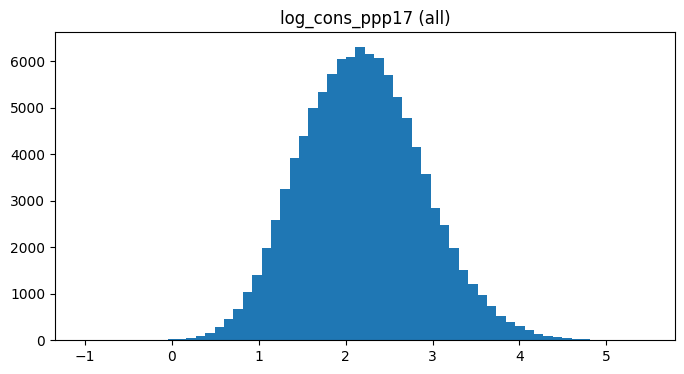

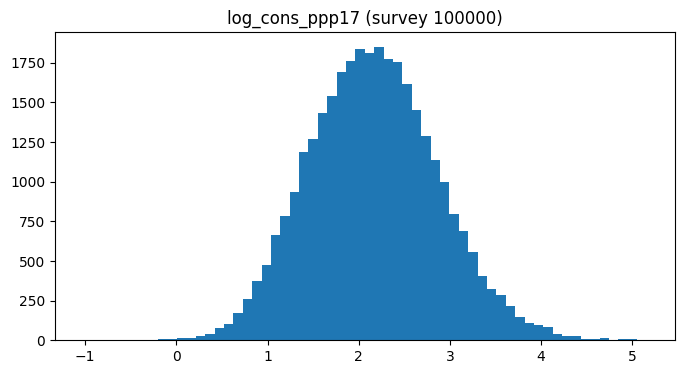

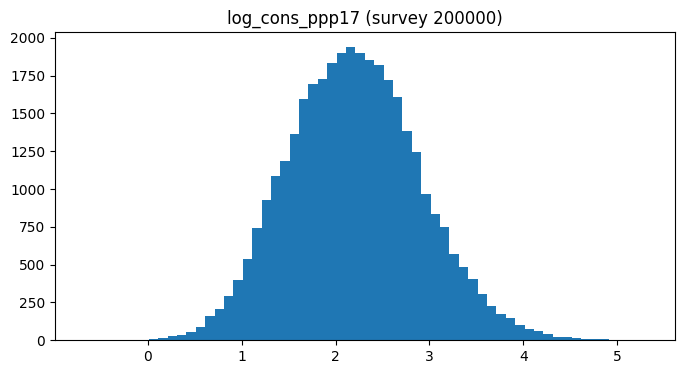

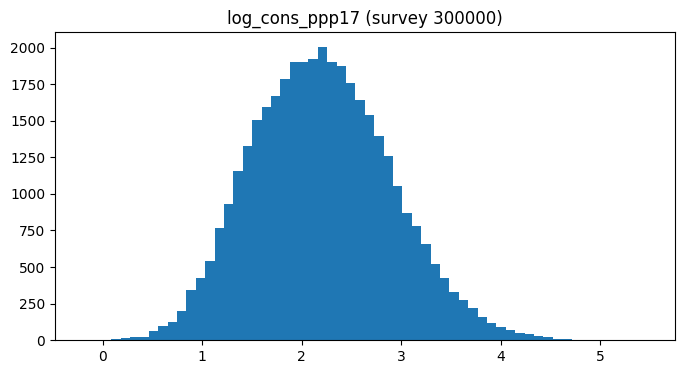

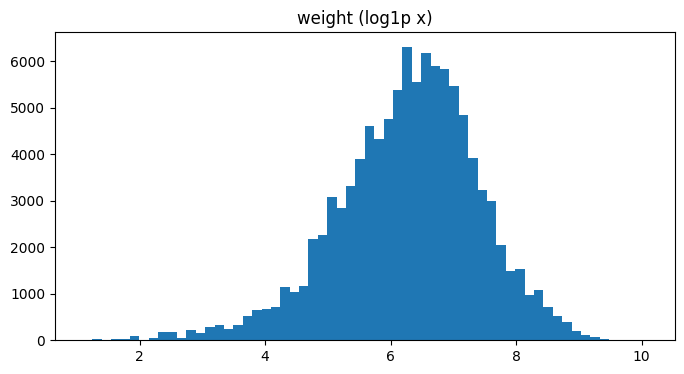

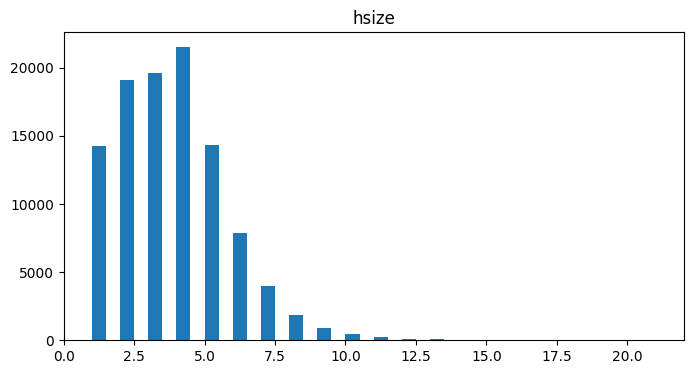

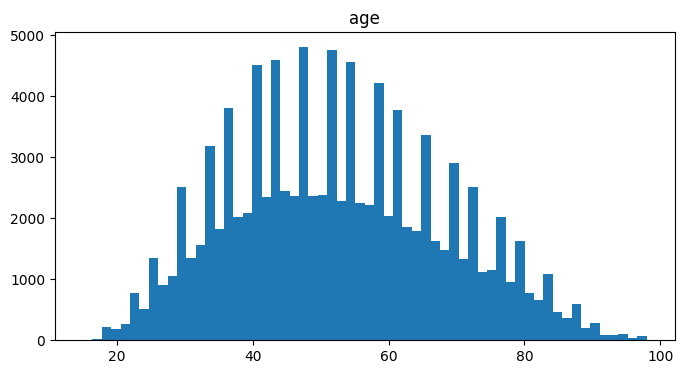

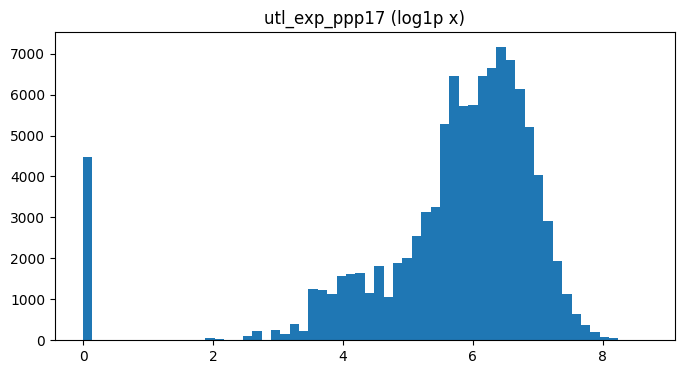

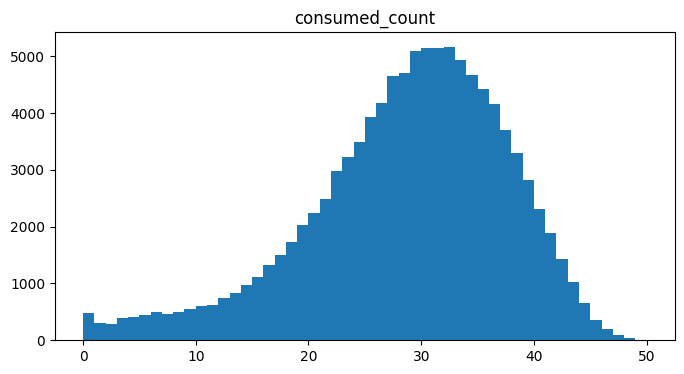

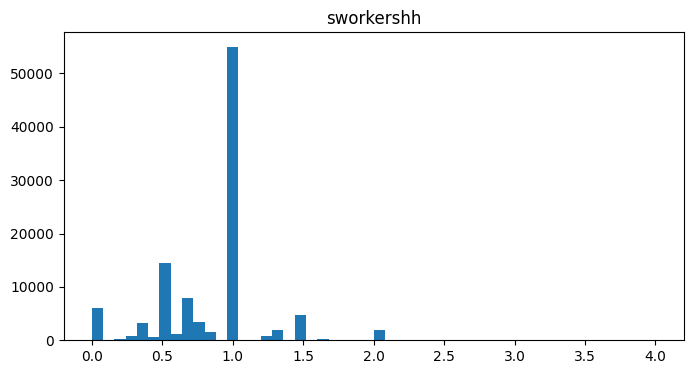

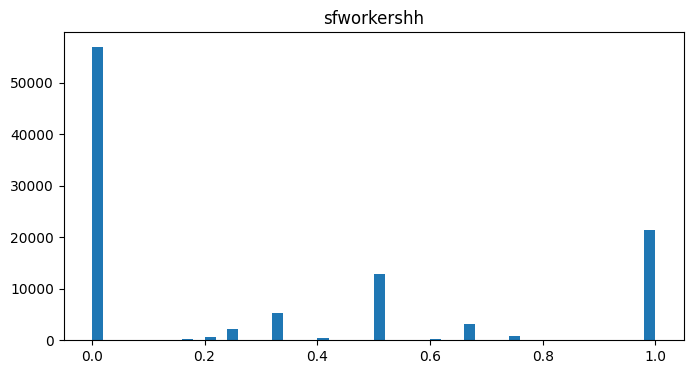

In [24]:
import matplotlib.pyplot as plt

# Helper: simple histogram
def plot_hist(series, title, bins=50, logx=False):
    s = series.dropna()
    if logx:
        s = np.log1p(s)
        title = title + " (log1p x)"
    plt.figure(figsize=(8,4))
    plt.hist(s, bins=bins)
    plt.title(title)
    plt.show()

# 1) Target distributions
plot_hist(train_df["log_cons_ppp17"], "log_cons_ppp17 (all)", bins=60)

for sid in sorted(train_df["survey_id"].unique()):
    plot_hist(train_df.loc[train_df["survey_id"] == sid, "log_cons_ppp17"],
              f"log_cons_ppp17 (survey {sid})", bins=60)

# 2) Weights
plot_hist(train_df["weight"], "weight", bins=60, logx=True)

# 3) Key numeric features
plot_hist(train_df["hsize"], "hsize", bins=40)
plot_hist(train_df["age"], "age", bins=60)
plot_hist(train_df["utl_exp_ppp17"], "utl_exp_ppp17", bins=60, logx=True)
plot_hist(train_df["consumed_count"], "consumed_count", bins=50)

plot_hist(train_df["sworkershh"], "sworkershh", bins=50)
plot_hist(train_df["sfworkershh"], "sfworkershh", bins=50)


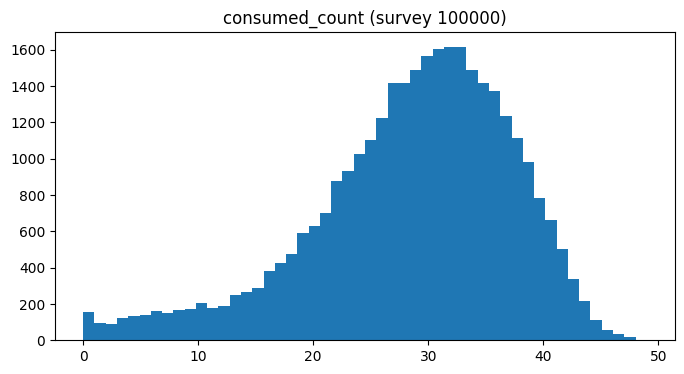

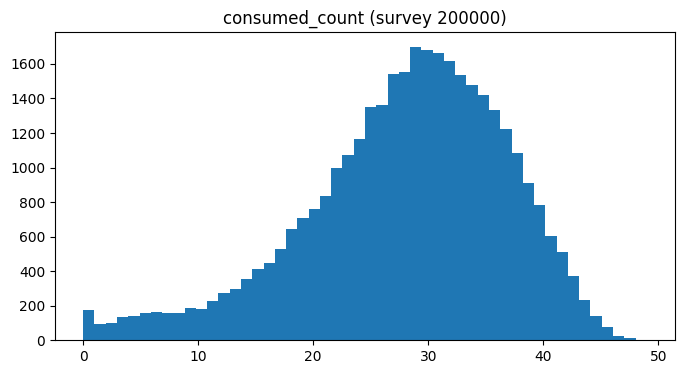

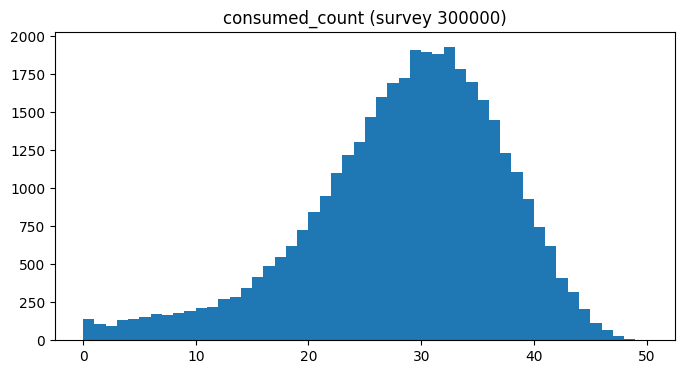

In [25]:
for sid in sorted(train_df["survey_id"].unique()):
    plot_hist(train_df.loc[train_df["survey_id"] == sid, "consumed_count"],
              f"consumed_count (survey {sid})", bins=50)


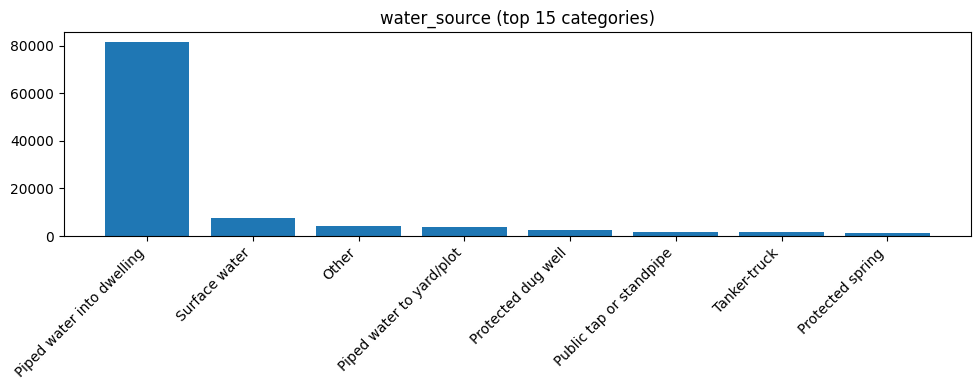

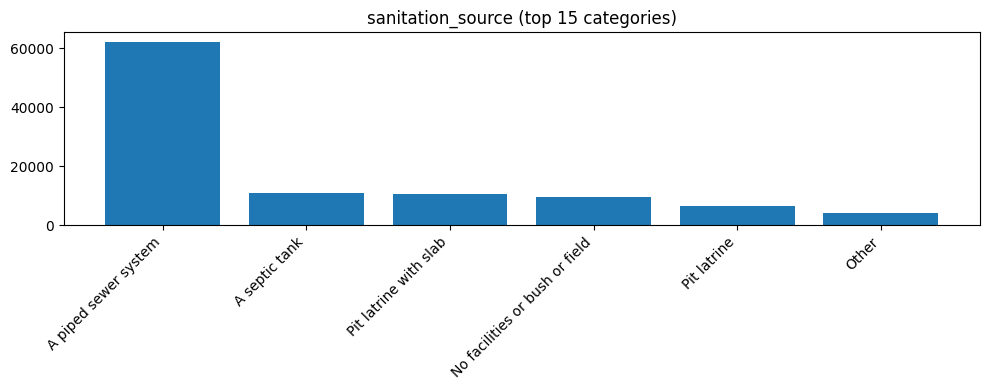

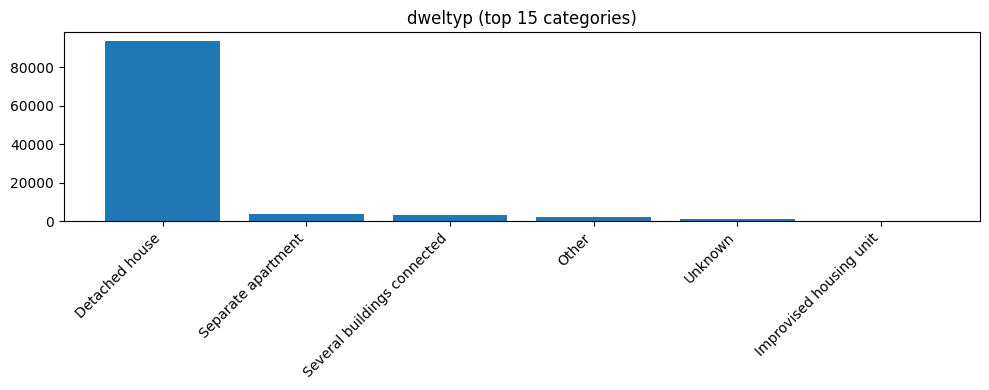

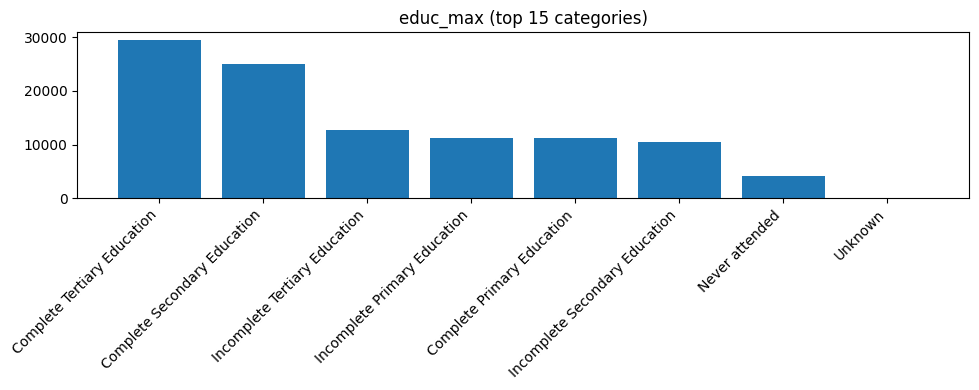

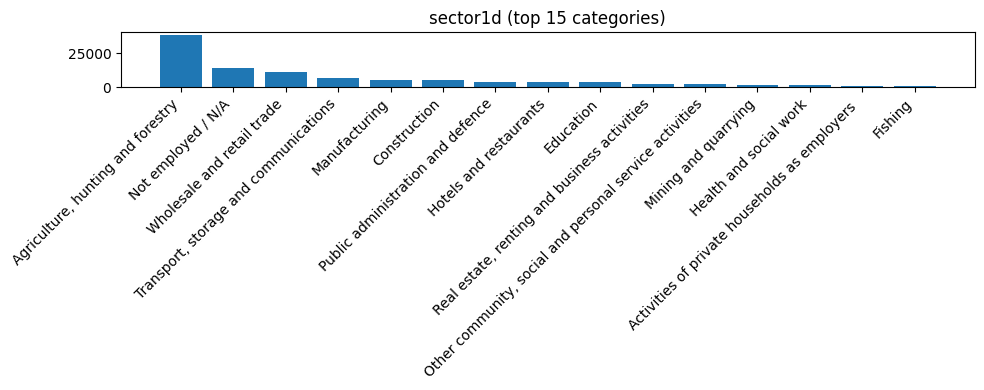

In [26]:
cat_cols = ["water_source", "sanitation_source", "dweltyp", "educ_max", "sector1d"]

for col in cat_cols:
    plt.figure(figsize=(10,4))
    vc = train_df[col].value_counts().head(15)
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(f"{col} (top 15 categories)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()



Label Encoding για categorical features με >2 κατηγορίες
Χρησιμοποιούμε LabelEncoder και κρατάμε mapping για consistency


In [27]:


from sklearn.preprocessing import LabelEncoder

# Categorical columns που χρειάζονται encoding
categorical_to_encode = ['water_source', 'sanitation_source', 'dweltyp', 'educ_max', 'sector1d']

# Dictionary για να κρατήσουμε τους encoders
label_encoders = {}

print("Encoding categorical features...")
for col in categorical_to_encode:
    if col in train_df.columns:
        # Initialize encoder
        le = LabelEncoder()
        
        # Combine train + test values για consistent encoding
        all_values = pd.concat([
            train_df[col].astype(str),
            test_features[col].astype(str)
        ]).unique()
        
        # Fit encoder
        le.fit(all_values)
        label_encoders[col] = le
        
        # Transform
        train_df[col] = le.transform(train_df[col].astype(str))
        test_features[col] = le.transform(test_features[col].astype(str))
        
        print(f"  ✓ {col}: {len(le.classes_)} categories → [0, {len(le.classes_)-1}]")

print(f"\nTotal categorical columns encoded: {len(label_encoders)}")

Encoding categorical features...
  ✓ water_source: 8 categories → [0, 7]
  ✓ sanitation_source: 6 categories → [0, 5]
  ✓ dweltyp: 6 categories → [0, 5]
  ✓ educ_max: 8 categories → [0, 7]
  ✓ sector1d: 18 categories → [0, 17]

Total categorical columns encoded: 5


Αντιμετώπιση NaN στα numeric features
Στρατηγική: Median imputation για continuous features

In [28]:
# Identify numeric columns με NaN
FEATURE_COLS_UPDATED = [c for c in train_df.columns 
                        if c not in ['survey_id', 'hhid', 'cons_ppp17', 
                                   'log_cons_ppp17', 'weight']]

numeric_cols_with_nan = []
for col in FEATURE_COLS_UPDATED:
    if train_df[col].dtype in ['int64', 'float64', 'int8']:
        if train_df[col].isna().sum() > 0:
            numeric_cols_with_nan.append(col)

print(f"Numeric columns with NaN: {len(numeric_cols_with_nan)}")
for col in numeric_cols_with_nan:
    nan_count = train_df[col].isna().sum()
    print(f"  {col}: {nan_count} NaN ({nan_count/len(train_df)*100:.2f}%)")

# Impute με median (robust to outliers)
impute_values = {}

for col in numeric_cols_with_nan:
    # Calculate median από train (excluding NaN)
    median_val = train_df[col].median()
    impute_values[col] = median_val
    
    # Fill NaN
    train_df[col] = train_df[col].fillna(median_val)
    
    # Same για test
    if col in test_features.columns:
        test_features[col] = test_features[col].fillna(median_val)
    
    print(f"  ✓ {col}: filled with median = {median_val:.4f}")

print(f"\nRemaining NaN in features:")
print(f"  Train: {train_df[FEATURE_COLS_UPDATED].isna().sum().sum()}")
print(f"  Test: {test_features[FEATURE_COLS_UPDATED].isna().sum().sum()}")

Numeric columns with NaN: 0

Remaining NaN in features:
  Train: 0
  Test: 0


Πιο προχωρημένο feature engineering για consumed columns
Δημιουργούμε features based on food groups

In [29]:
# Update consumed_cols list
consumed_cols = [c for c in FEATURE_COLS_UPDATED if c.startswith('consumed') and c != 'consumed_count']

print(f"Creating food group features from {len(consumed_cols)} consumed columns...")

# Helper function για να βρούμε consumed columns by code range
def get_consumed_in_range(start, end):
    return [c for c in consumed_cols 
            if start <= int(c.replace('consumed', '')) <= end]

# 1. BASIC STAPLES (breads, rice, potato, sugar, egg) - 100-700
staples = get_consumed_in_range(100, 700)
train_df['consumed_staples'] = train_df[staples].sum(axis=1)
test_features['consumed_staples'] = test_features[staples].sum(axis=1)
print(f"  ✓ consumed_staples: {len(staples)} items")

# 2. PROTEINS (meat, poultry, offal) - 800-1400
proteins_meat = get_consumed_in_range(800, 1400)
train_df['consumed_proteins_meat'] = train_df[proteins_meat].sum(axis=1)
test_features['consumed_proteins_meat'] = test_features[proteins_meat].sum(axis=1)
print(f"  ✓ consumed_proteins_meat: {len(proteins_meat)} items")

# 3. GRAINS & LEGUMES - 1500-1900
grains = get_consumed_in_range(1500, 1900)
train_df['consumed_grains'] = train_df[grains].sum(axis=1)
test_features['consumed_grains'] = test_features[grains].sum(axis=1)
print(f"  ✓ consumed_grains: {len(grains)} items")

# 4. FISH & SEAFOOD - 2000-2200
fish = get_consumed_in_range(2000, 2200)
train_df['consumed_fish'] = train_df[fish].sum(axis=1)
test_features['consumed_fish'] = test_features[fish].sum(axis=1)
print(f"  ✓ consumed_fish: {len(fish)} items")

# 5. DAIRY & FATS - 2300-2700
dairy = get_consumed_in_range(2300, 2700)
train_df['consumed_dairy'] = train_df[dairy].sum(axis=1)
test_features['consumed_dairy'] = test_features[dairy].sum(axis=1)
print(f"  ✓ consumed_dairy: {len(dairy)} items")

# 6. SPICES & VEGETABLES - 2800-3700
vegetables = get_consumed_in_range(2800, 3700)
train_df['consumed_vegetables'] = train_df[vegetables].sum(axis=1)
test_features['consumed_vegetables'] = test_features[vegetables].sum(axis=1)
print(f"  ✓ consumed_vegetables: {len(vegetables)} items")

# 7. FRUITS - 3800-4200
fruits = get_consumed_in_range(3800, 4200)
train_df['consumed_fruits'] = train_df[fruits].sum(axis=1)
test_features['consumed_fruits'] = test_features[fruits].sum(axis=1)
print(f"  ✓ consumed_fruits: {len(fruits)} items")

# 8. BEVERAGES & PREPARED - 4300-5000
beverages = get_consumed_in_range(4300, 5000)
train_df['consumed_beverages'] = train_df[beverages].sum(axis=1)
test_features['consumed_beverages'] = test_features[beverages].sum(axis=1)
print(f"  ✓ consumed_beverages: {len(beverages)} items")

# 9. DIVERSITY RATIO (what % of asked items were consumed)
# consumed_count ήδη υπάρχει
train_df['consumed_diversity_ratio'] = train_df['consumed_count'] / len(consumed_cols)
test_features['consumed_diversity_ratio'] = test_features['consumed_count'] / len(consumed_cols)
print(f"  ✓ consumed_diversity_ratio: proportion of items consumed")

# Summary
new_food_features = [
    'consumed_staples', 'consumed_proteins_meat', 'consumed_grains',
    'consumed_fish', 'consumed_dairy', 'consumed_vegetables',
    'consumed_fruits', 'consumed_beverages', 'consumed_diversity_ratio'
]

print(f"\nCreated {len(new_food_features)} new food group features")
print("\nCorrelations with log_cons_ppp17:")
for feat in new_food_features:
    corr = train_df[[feat, 'log_cons_ppp17']].corr().iloc[0, 1]
    print(f"  {feat:30s}: {corr:+.4f}")

Creating food group features from 50 consumed columns...
  ✓ consumed_staples: 7 items
  ✓ consumed_proteins_meat: 7 items
  ✓ consumed_grains: 5 items
  ✓ consumed_fish: 3 items
  ✓ consumed_dairy: 5 items
  ✓ consumed_vegetables: 10 items
  ✓ consumed_fruits: 5 items
  ✓ consumed_beverages: 8 items
  ✓ consumed_diversity_ratio: proportion of items consumed

Created 9 new food group features

Correlations with log_cons_ppp17:
  consumed_staples              : +0.0863
  consumed_proteins_meat        : +0.1956
  consumed_grains               : -0.0259
  consumed_fish                 : +0.1665
  consumed_dairy                : +0.3077
  consumed_vegetables           : +0.0020
  consumed_fruits               : +0.1397
  consumed_beverages            : +0.3551
  consumed_diversity_ratio      : +0.1921


Προσδιορισμός των numeric features που χρειάζονται scaling
ΠΡΟΣΟΧΗ: ΔΕΝ κάνουμε scale:
- IDs (survey_id, hhid)
- Targets (cons_ppp17, log_cons_ppp17)
- Weight
- Binary features (0/1)
- Label-encoded categoricals
- Consumed binary indicators

In [30]:
# Update feature list after all transformations
FINAL_FEATURE_COLS = [c for c in train_df.columns 
                      if c not in ['survey_id', 'hhid', 'cons_ppp17', 
                                 'log_cons_ppp17', 'weight']]

# Columns που ΔΕΝ πρέπει να scale
NO_SCALE_COLS = []

# 1. Binary features (already 0/1)
binary_features = ['male', 'owner', 'water', 'toilet', 'sewer', 'elect',
                   'employed', 'any_nonagric', 'urban'] + \
                  [f'region{i}' for i in range(1, 8)] + \
                  consumed_cols  # All consumed are 0/1

NO_SCALE_COLS.extend(binary_features)

# 2. Label-encoded categoricals (ordinal integers)
NO_SCALE_COLS.extend(categorical_to_encode)

# 3. ID-like features
NO_SCALE_COLS.extend(['strata'])

# Numeric columns που ΠΡΕΠΕΙ να scale
numeric_to_scale = []
for col in FINAL_FEATURE_COLS:
    if col not in NO_SCALE_COLS:
        if train_df[col].dtype in ['int64', 'float64', 'int8', 'int16', 'int32']:
            numeric_to_scale.append(col)

print(f"Total feature columns: {len(FINAL_FEATURE_COLS)}")
print(f"Columns NOT to scale: {len([c for c in NO_SCALE_COLS if c in FINAL_FEATURE_COLS])}")
print(f"Columns TO scale: {len(numeric_to_scale)}")
print(f"\nNumeric columns for scaling:")
for col in numeric_to_scale:
    print(f"  - {col}")

Total feature columns: 94
Columns NOT to scale: 72
Columns TO scale: 22

Numeric columns for scaling:
  - utl_exp_ppp17
  - hsize
  - num_children5
  - num_children10
  - num_children18
  - age
  - num_adult_female
  - num_adult_male
  - num_elderly
  - sworkershh
  - share_secondary
  - sfworkershh
  - consumed_count
  - consumed_staples
  - consumed_proteins_meat
  - consumed_grains
  - consumed_fish
  - consumed_dairy
  - consumed_vegetables
  - consumed_fruits
  - consumed_beverages
  - consumed_diversity_ratio


Scaling των numeric features χρησιμοποιώντας StandardScaler
Fit στο train, transform σε train & test

In [31]:
from sklearn.preprocessing import StandardScaler

if len(numeric_to_scale) > 0:
    print(f"Scaling {len(numeric_to_scale)} numeric features...")
    
    # Initialize scaler
    scaler = StandardScaler()
    
    # Fit on train data
    scaler.fit(train_df[numeric_to_scale])
    
    # Transform both train and test
    train_df[numeric_to_scale] = scaler.transform(train_df[numeric_to_scale])
    test_features[numeric_to_scale] = scaler.transform(test_features[numeric_to_scale])
    
    print("✓ Scaling completed!")
    
    # Show scaled statistics
    print("\nScaled features statistics (should have mean≈0, std≈1):")
    print(train_df[numeric_to_scale].describe().loc[['mean', 'std', 'min', 'max']])
    
    # Store scaler params for reference
    scaling_info = {
        col: {'mean': scaler.mean_[i], 'std': scaler.scale_[i]}
        for i, col in enumerate(numeric_to_scale)
    }
else:
    print("No numeric features to scale")
    scaling_info = {}

Scaling 22 numeric features...
✓ Scaling completed!

Scaled features statistics (should have mean≈0, std≈1):
      utl_exp_ppp17         hsize  num_children5  num_children10  \
mean   1.897798e-16 -2.181377e-17   3.572005e-17   -7.662088e-17   
std    1.000005e+00  1.000005e+00   1.000005e+00    1.000005e+00   
min   -1.167057e+00 -1.354682e+00  -5.125193e-01   -5.650651e-01   
max    1.228004e+01  9.019456e+00   8.389357e+00    9.463709e+00   

      num_children18           age  num_adult_female  num_adult_male  \
mean   -8.452837e-17  1.709654e-16      9.543525e-17   -7.471217e-17   
std     1.000005e+00  1.000005e+00      1.000005e+00    1.000005e+00   
min    -6.867418e-01 -2.389317e+00     -1.448601e+00   -1.295503e+00   
max     6.529412e+00  2.886458e+00      7.642307e+00    8.665621e+00   

       num_elderly    sworkershh  ...  consumed_count  consumed_staples  \
mean  6.912239e-17 -3.512017e-16  ...   -1.145223e-17     -1.374268e-16   
std   1.000005e+00  1.000005e+00  ...  

Τελικός έλεγχος πριν το save

In [32]:
print("="*70)
print("FINAL DATA VALIDATION")
print("="*70)

# 1. Missing values check
print("\n1. Missing Values:")
train_missing = train_df[FINAL_FEATURE_COLS].isna().sum().sum()
test_missing = test_features[FINAL_FEATURE_COLS].isna().sum().sum()
print(f"   Train features: {train_missing} NaN")
print(f"   Test features: {test_missing} NaN")

if train_missing > 0 or test_missing > 0:
    print("\n   ⚠️  WARNING: There are still missing values!")
    print("   Columns with NaN (train):")
    print(train_df[FINAL_FEATURE_COLS].isna().sum()[lambda x: x > 0])

# 2. Infinite values check
print("\n2. Infinite Values:")
train_inf = np.isinf(train_df.select_dtypes(include=[np.number])).sum().sum()
test_inf = np.isinf(test_features.select_dtypes(include=[np.number])).sum().sum()
print(f"   Train: {train_inf} infinite values")
print(f"   Test: {test_inf} infinite values")

# 3. Data types
print("\n3. Data Types Distribution:")
print(train_df[FINAL_FEATURE_COLS].dtypes.value_counts())

# 4. Feature alignment
train_feats = set(FINAL_FEATURE_COLS)
test_feats = set([c for c in test_features.columns if c not in ['survey_id', 'hhid', 'weight']])
print(f"\n4. Feature Alignment:")
print(f"   Train features: {len(train_feats)}")
print(f"   Test features: {len(test_feats)}")
print(f"   Match: {train_feats == test_feats}")

if train_feats != test_feats:
    print(f"   Missing in test: {train_feats - test_feats}")
    print(f"   Extra in test: {test_feats - train_feats}")

# 5. Shape check
print(f"\n5. Final Shapes:")
print(f"   Train: {train_df.shape}")
print(f"   Test: {test_features.shape}")

# 6. Target check
print(f"\n6. Target Distribution:")
print(f"   cons_ppp17: [{train_df['cons_ppp17'].min():.2f}, {train_df['cons_ppp17'].max():.2f}]")
print(f"   log_cons_ppp17: [{train_df['log_cons_ppp17'].min():.2f}, {train_df['log_cons_ppp17'].max():.2f}]")

print("\n" + "="*70)
print("✓ VALIDATION COMPLETE")
print("="*70)

FINAL DATA VALIDATION

1. Missing Values:
   Train features: 0 NaN
   Test features: 0 NaN

2. Infinite Values:
   Train: 0 infinite values
   Test: 0 infinite values

3. Data Types Distribution:
int8       59
float64    22
int64       8
int32       5
Name: count, dtype: int64

4. Feature Alignment:
   Train features: 94
   Test features: 94
   Match: True

5. Final Shapes:
   Train: (104234, 99)
   Test: (103023, 97)

6. Target Distribution:
   cons_ppp17: [0.36, 236.12]
   log_cons_ppp17: [-1.02, 5.46]

✓ VALIDATION COMPLETE



Save processed data & metadata


In [33]:


import json
from pathlib import Path

# Create output directory
output_dir = Path("c:/Users/user/poverty-prediction/data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

# Define column order for saving
SAVE_COLS_TRAIN = (
    ['survey_id', 'hhid', 'weight', 'cons_ppp17', 'log_cons_ppp17'] +
    [c for c in train_df.columns if c not in 
     ['survey_id', 'hhid', 'weight', 'cons_ppp17', 'log_cons_ppp17']]
)

SAVE_COLS_TEST = (
    ['survey_id', 'hhid', 'weight'] +
    [c for c in test_features.columns if c not in ['survey_id', 'hhid', 'weight']]
)

# Save datasets
print("Saving processed datasets...")
train_df[SAVE_COLS_TRAIN].to_csv(
    output_dir / "train_processed.csv", 
    index=False
)
print(f"  ✓ train_processed.csv: {train_df.shape}")

test_features[SAVE_COLS_TEST].to_csv(
    output_dir / "test_processed.csv", 
    index=False
)
print(f"  ✓ test_processed.csv: {test_features.shape}")

# Save comprehensive metadata
metadata = {
    "processing_date": pd.Timestamp.now().isoformat(),
    "train_shape": list(train_df.shape),
    "test_shape": list(test_features.shape),
    
    # Targets
    "target_col": "log_cons_ppp17",
    "raw_target_col": "cons_ppp17",
    "target_range": {
        "cons_ppp17": [float(train_df['cons_ppp17'].min()), 
                       float(train_df['cons_ppp17'].max())],
        "log_cons_ppp17": [float(train_df['log_cons_ppp17'].min()), 
                          float(train_df['log_cons_ppp17'].max())]
    },
    
    # IDs & Weight
    "weight_col": "weight",
    "id_cols": ["survey_id", "hhid"],
    
    # Feature counts
    "total_features": len(FINAL_FEATURE_COLS),
    "numeric_scaled": len(numeric_to_scale),
    "binary_features": len([c for c in binary_features if c in FINAL_FEATURE_COLS]),
    "categorical_encoded": len(categorical_to_encode),
    "consumed_original": len(consumed_cols),
    "consumed_engineered": 9,
    
    # Feature lists
    "feature_columns": FINAL_FEATURE_COLS,
    "numeric_scaled_cols": numeric_to_scale,
    "binary_cols": [c for c in binary_features if c in FINAL_FEATURE_COLS],
    "categorical_cols": categorical_to_encode,
    "consumed_cols": consumed_cols,
    "food_group_features": [
        'consumed_staples', 'consumed_proteins_meat', 'consumed_grains',
        'consumed_fish', 'consumed_dairy', 'consumed_vegetables',
        'consumed_fruits', 'consumed_beverages', 'consumed_diversity_ratio'
    ],
    
    # Encoders (για reference)
    "label_encoders": {
        col: le.classes_.tolist() 
        for col, le in label_encoders.items()
    },
    
    # Scaling info
    "scaler_info": scaling_info if 'scaling_info' in locals() else {},
    
    # Imputation (if any was done)
    "impute_values": impute_values if 'impute_values' in locals() else {},
    
    # Data quality
    "data_quality": {
        "train_missing_values": 0,
        "test_missing_values": 0,
        "train_infinite_values": 0,
        "test_infinite_values": 0,
        "feature_alignment_match": True
    }
}

# Save metadata
with open(output_dir / "processing_metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"\n✓ Saved metadata: processing_metadata.json")

# Print summary
print("\n" + "="*70)
print("SAVE COMPLETE!")
print("="*70)
print(f"\nOutput directory: {output_dir}")
print(f"\nFiles created:")
print(f"  1. train_processed.csv ({train_df.shape[0]} rows × {train_df.shape[1]} cols)")
print(f"  2. test_processed.csv ({test_features.shape[0]} rows × {test_features.shape[1]} cols)")
print(f"  3. processing_metadata.json")
print(f"\nFeature summary:")
print(f"  - Total features: {len(FINAL_FEATURE_COLS)}")
print(f"  - Numeric scaled: {len(numeric_to_scale)}")
print(f"  - Binary: {len([c for c in binary_features if c in FINAL_FEATURE_COLS])}")
print(f"  - Categorical encoded: {len(categorical_to_encode)}")
print(f"  - Consumed (original): {len(consumed_cols)}")
print(f"  - Food groups (engineered): 9")
print("\n✓ Ready for modeling!")

Saving processed datasets...
  ✓ train_processed.csv: (104234, 99)
  ✓ test_processed.csv: (103023, 97)

✓ Saved metadata: processing_metadata.json

SAVE COMPLETE!

Output directory: c:\Users\user\poverty-prediction\data\processed

Files created:
  1. train_processed.csv (104234 rows × 99 cols)
  2. test_processed.csv (103023 rows × 97 cols)
  3. processing_metadata.json

Feature summary:
  - Total features: 94
  - Numeric scaled: 22
  - Binary: 66
  - Categorical encoded: 5
  - Consumed (original): 50
  - Food groups (engineered): 9

✓ Ready for modeling!
